# Imports

In [25]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split

# Setting random seeds

In [26]:
np.random.seed(5)
tf.random.set_seed(5)

# Load MNIST Dataset

In [27]:
#We first load our data, and seek the distribution for its labels
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Create our labels array
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

In [28]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train val test split

In [29]:
X_train = X_train / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 10)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.90, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.9, random_state=42)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4200, 28, 28, 1)
(3780, 28, 28, 1)
(34020, 28, 28, 1)


True label: 0


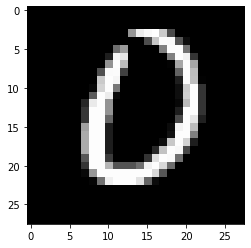

In [31]:
sample_number = 10
X_train[sample_number, :, :, 0]
plt.imshow(X_train[sample_number, :, :, 0], cmap='gist_gray')
print("True label: {}".format(np.argmax(Y_train[sample_number], axis=-1)))

In [32]:
X_train.shape[1:]

(28, 28, 1)

# Bayesian CNN

In [33]:
model_in = tf.keras.layers.Input(shape=(28,28,1))

conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
x = conv_1(model_in)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
x = conv_2(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Flatten()(x)

dense_1 = tfp.python.layers.DenseFlipout(100, activation='relu')
x = dense_1(x)

dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
model_out = dense_2(x)  

model = tf.keras.Model(model_in, model_out)

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 14, 14, 32)        608       
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0   

# Evidence lower bound loss function

In [35]:
@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [36]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

In [37]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)

# Main training loop + Uncertainty at training
To measure uncertainty at training, we measure the std dev of the loss of a testing set at the end of each epoch.  
If the std dev goes down that means our model is getting less uncertain over time.

In [38]:
epochs = 40

times = [] # Stores how much time each training loop took
accs = [] # Stores training accuracy at every epoch
val_accs = [] # Stores validation accuracy at every epoch
losses = [] # loss per epoch
val_losses = [] # val_loss per epoch

y_pred_list_0 = {} # stores the std dev of loss per epoch (key is epoch, value is std dev of 10 loss vals)

for i in range(epochs):
    tic = time.time()
    loss = train_step(X_train, Y_train)
    preds = model(X_train)
    acc = accuracy(preds, Y_train)
    accs.append(acc)
    losses.append(loss)
    
    val_preds = model(X_val)
    val_loss = elbo_loss(Y_val, val_preds)
    val_acc = accuracy(Y_val, val_preds)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    
    loss_temp = [] # Stores the loss of 10 mc predictions over the testing set
    for j in range(10):
        y_pred = model.predict(X_test)
        loss_temp.append(elbo_loss(Y_test,y_pred))
        
    # Get std dev of losses and store it 
    y_sigma = np.std(loss_temp)
    y_pred_list_0[i] = y_sigma

    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    
    print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, val_loss = {:7.3f}, val_acc={:7.3f} time: {:7.3f}".format(i, loss, acc, val_loss, val_acc, train_time))

Epoch: 0: loss =  10.499 , accuracy =   0.134, val_loss =   4.440, val_acc=  0.124 time:  18.497
Epoch: 1: loss =   4.369 , accuracy =   0.150, val_loss =   3.276, val_acc=  0.155 time:  15.103
Epoch: 2: loss =   3.193 , accuracy =   0.156, val_loss =   3.165, val_acc=  0.149 time:  16.130
Epoch: 3: loss =   3.083 , accuracy =   0.194, val_loss =   2.632, val_acc=  0.196 time:  19.212
Epoch: 4: loss =   2.625 , accuracy =   0.205, val_loss =   2.443, val_acc=  0.204 time:  14.931
Epoch: 5: loss =   2.505 , accuracy =   0.260, val_loss =   2.151, val_acc=  0.255 time:  18.839
Epoch: 6: loss =   2.105 , accuracy =   0.366, val_loss =   1.882, val_acc=  0.367 time:  18.884
Epoch: 7: loss =   1.872 , accuracy =   0.465, val_loss =   1.713, val_acc=  0.476 time:  17.650
Epoch: 8: loss =   1.712 , accuracy =   0.508, val_loss =   1.601, val_acc=  0.487 time:  19.486
Epoch: 9: loss =   1.581 , accuracy =   0.552, val_loss =   1.466, val_acc=  0.534 time:  20.005
Epoch: 10: loss =   1.471 , ac

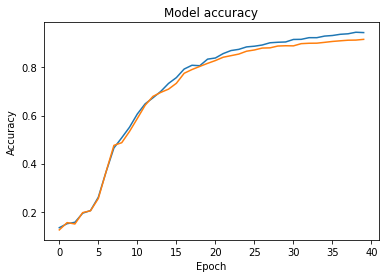

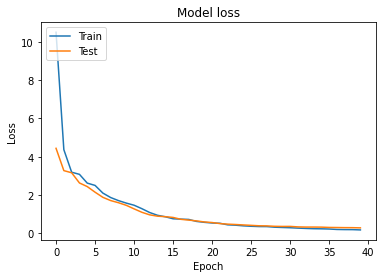

In [39]:
plt.plot(np.array(accs), label="acc")
plt.plot(np.array(val_accs), label="val_acc")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(np.array(losses), label="loss")
plt.plot(np.array(val_losses), label="val_loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training uncertainty
Loop over each epoch and plot the std dev (of the 10 losses) recorded.  
If curve is increasing then the model is getting highly uncertain over epochs.  
If curve is decreasing then the model is getting less uncertain over epochs.  
If curve stays the same then the model is probably not improving, might be a good sign or a bad sign depending on the model accuracy etc..

0.048265815
0.022173986
0.027799655
0.012545636
0.020660583
0.010300432
0.010840398
0.005306246
0.00633142
0.009196009
0.0059717097
0.0040673395
0.006441407
0.015308632
0.012539041
0.0141427545
0.008119058
0.010637057
0.0085798465
0.010544344
0.008064827
0.0063860314
0.008717332
0.0058523347
0.008628605
0.0091393385
0.006519063
0.0063053523
0.005720122
0.0049735103
0.0076960973
0.0075257146
0.007317399
0.005233287
0.0060562934
0.0042171916
0.005943079
0.008257095
0.0075333915
0.007940082


<Figure size 432x288 with 0 Axes>

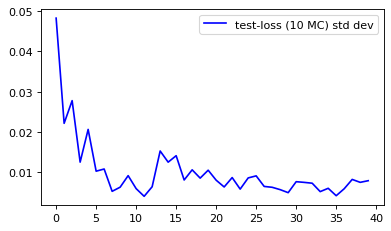

In [40]:
from matplotlib.pyplot import figure


fig = plt.figure()
figure(figsize=(5, 3), dpi=80)
fig.subplots_adjust(hspace=1.9, wspace=1.9)

vals = []
for i in range(epochs):
        print(np.array(y_pred_list_0[i]))
        vals.append(np.array(y_pred_list_0[i]))
    
t = np.linspace(0,nb_epochs-1,nb_epochs)
plt.plot(t, vals, 'b-', label='test-loss (10 MC) std dev')
plt.tight_layout()

    
plt.legend()
plt.show()    

## Uncertainty at Inference
For each testing sample perform inference *mc_samples* times.
At each inference record the predicted classes. Finally, plot the density of the predicted classes to check whether the model is consistently predicting the correct class

Label: 6


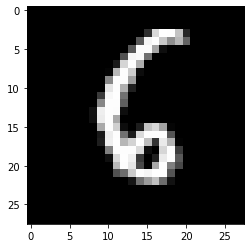

In [41]:
# Test random image
img_index = 15
test_image = X_val[img_index, :, :, 0] # Get image data
label = Y_val[img_index] # Get image label

# Plot
plt.imshow(test_image, cmap='gist_gray')
print("Label: {}".format(np.argmax(label), axis=-1))

In [42]:
# Inference
mc_samples = 20 # Perform inference *mc_samples* times
thresh = 0.2 # Threshold to indicate that the right class has been chosen.

# If a given number (column) has the probability to be guessed by the model (more than the threshold)
# Then it is flagged as a possible result

# For each inference record the output classes probas
preds = [model(X_val[img_index:img_index+1, :, :, :]) for _ in range(mc_samples)]
# Perform softmax and concatenate results over columns (or in other term, group results per label)
preds = np.concatenate([tf.nn.softmax(y, axis = -1)[:, :, np.newaxis] for y in preds], axis=-1)
# Get the probability of each label being activated
prob_of_nums = [[np.sum(y)/mc_samples for y in pred_row] for pred_row in preds]
# Record the average probability per label
preds = [[int((np.sum(y)/mc_samples) >= thresh) for y in pred_row] for pred_row in preds]
preds = np.array(preds)

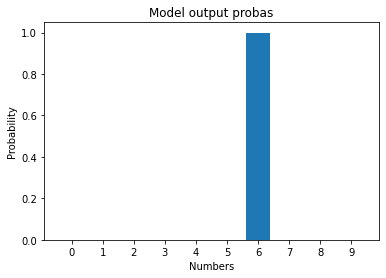

In [43]:
# Plot probabilities of each label
x = np.arange(10)
plt.bar(x, prob_of_nums[0], align='center')
plt.xticks(x)
plt.xlabel("Numbers")
plt.ylabel('Probability')
plt.title('Model output probas')
plt.show()

# Noise example

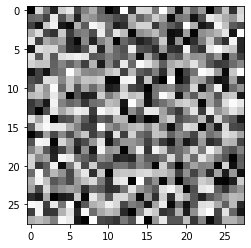

In [45]:
# Noise
noise = np.random.random((28,28,1))
plt.imshow(noise[:, :, 0], cmap='gist_gray')

In [49]:
# Inference
mc_samples = 10
med_thresh = 0.2

preds = [model(np.array([noise])) for _ in range(mc_samples)]
preds = np.concatenate([tf.nn.softmax(y, axis = -1)[:, :, np.newaxis] for y in preds], axis=-1)
prob_of_nums = [[np.sum(y)/mc_samples for y in pred_row] for pred_row in preds]
preds = [[int((np.sum(y)/mc_samples) >= med_thresh) for y in pred_row] for pred_row in preds]
preds = np.array(preds)

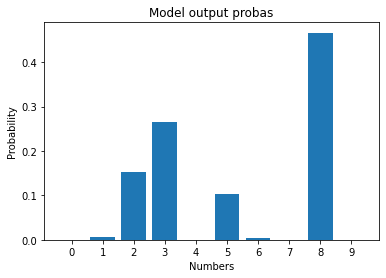

In [50]:
x = np.arange(10)
plt.bar(x, prob_of_nums[0], align='center')
plt.xticks(x)
plt.xlabel("Numbers")
plt.ylabel('Probability')
plt.title('Model output probas')
plt.show()

In [52]:
value_counts = np.bincount(preds.flatten())
nb_zeros = value_counts[0]
nb_ones = value_counts[1]
if nb_outputs == nb_zeros:
    print("Model doesn't know ")
else:
    indeces = np.where(preds[0] == 1)[0]
    if nb_ones == 1:
        print("The model thinks the number is {}".format(indeces[0]))
    elif nb_ones > 1:
        print("The model is confused between ")
        [print(i) for i in indeces]

The model is confused between 
3
8


# Frequentist CNN

In [51]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(256,256,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0

In [53]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [55]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'], optimizer=optimizer)

In [37]:
history = model.fit(X_train, Y_train, epochs=10, validation_split=0.1)

Epoch 1/10
178/178 [==============================] - 7s 39ms/step - loss: 1.2159 - accuracy: 0.6288 - val_loss: 0.1898 - val_accuracy: 0.9381
Epoch 2/10
178/178 [==============================] - 7s 37ms/step - loss: 0.2876 - accuracy: 0.9124 - val_loss: 0.1089 - val_accuracy: 0.9603
Epoch 3/10
178/178 [==============================] - 7s 37ms/step - loss: 0.2377 - accuracy: 0.9276 - val_loss: 0.0671 - val_accuracy: 0.9778
Epoch 4/10
178/178 [==============================] - 7s 37ms/step - loss: 0.1882 - accuracy: 0.9398 - val_loss: 0.0787 - val_accuracy: 0.9762
Epoch 5/10
178/178 [==============================] - 7s 39ms/step - loss: 0.1699 - accuracy: 0.9451 - val_loss: 0.0899 - val_accuracy: 0.9762
Epoch 6/10
178/178 [==============================] - 7s 41ms/step - loss: 0.1568 - accuracy: 0.9541 - val_loss: 0.0719 - val_accuracy: 0.9778
Epoch 7/10
178/178 [==============================] - 8s 45ms/step - loss: 0.1655 - accuracy: 0.9517 - val_loss: 0.0633 - val_accuracy: 0.9810

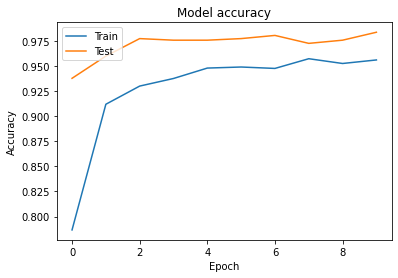

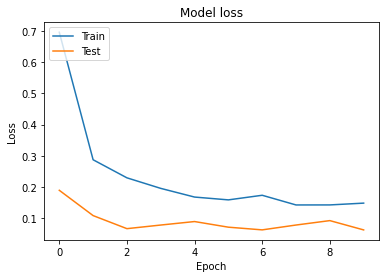

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
evaluation = model.evaluate(X_val, Y_val, verbose=1)
print(evaluation)

1116/1116 [==============================] - 6s 6ms/step - loss: 0.1239 - accuracy: 0.9673
[0.12389473617076874, 0.9672828912734985]


In [40]:
# Prediction for 1 image
sample_nb = 2
output = model(X_train[sample_nb:sample_nb+1, :, :, :])

Predicted label: 1


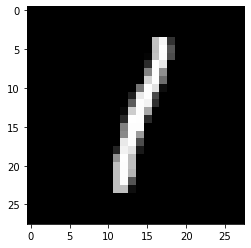

In [41]:
plt.imshow(X_train[sample_nb, :, :, 0], cmap='gist_gray')
print("Predicted label: {}".format(np.argmax(output[0]), axis=-1))

Predicted label: 8


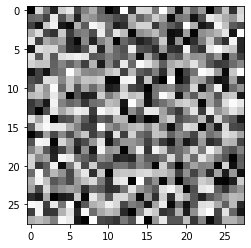

In [42]:
# Noise
noise = np.random.random((28,28,1))
pred_for_noise = model(np.array([noise]))
plt.imshow(noise[:, :, 0], cmap='gist_gray')
print("Predicted label: {}".format(np.argmax(pred_for_noise[0]), axis=-1))